In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
words=open('names.txt','r').read().splitlines()

In [5]:
#build voabulary of character and mapping to/from integrers
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
#vocab_size
vocab_size = len(itos)
print(vocab_size)

27


In [7]:
block_size=3
#build the datset

def build_dataset(words):
     #context lenght: how many inputs/characters we take to predict next char
    X,Y=[],[] #X are the inputs to NN, Y is the label for each input inside X

    for w in words: #gives the name/word ,first 5 so in loop it is emma
#         print(w)
        context=block_size*[0]   #1st loop : [0,0,0]
        for ch in w + '.':       #adds . to the name and gives the  letter here e
            ix=stoi[ch]          #gives corresponding int value of e and stores in ix
            X.append(context)    #adds [0,0,0] to X,list inside list
            Y.append(ix)         #add ix to Y, here for e
#             print(''.join(itos[i] for i in context),'--->',itos[ix])
            context=context[1:]+ [ix] #crop and append: before starting for m (next letter in emma), removes first 0 from context and adds the value of e as third elemnt in context 

    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y


import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev, Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g)
b1=torch.randn(n_hidden, generator=g)
W2=torch.randn((n_hidden,vocab_size), generator=g)
b2=torch.randn(27, generator=g)
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True

11897


In [9]:

#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact)
    logits=h @ W2 +b2 #32x27
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

        
        
# print(loss.item())
# this is loss for this particular minibatch

      0/ 200000: 27.8817
  10000/ 200000: 4.0974
  20000/ 200000: 2.9530
  30000/ 200000: 2.9583
  40000/ 200000: 2.3027
  50000/ 200000: 2.7252
  60000/ 200000: 2.4195
  70000/ 200000: 2.1045
  80000/ 200000: 2.2040
  90000/ 200000: 2.4836
 100000/ 200000: 2.0478
 110000/ 200000: 2.3888
 120000/ 200000: 2.0578
 130000/ 200000: 2.5195
 140000/ 200000: 2.4495
 150000/ 200000: 2.3045
 160000/ 200000: 2.0819
 170000/ 200000: 1.8631
 180000/ 200000: 2.2761
 190000/ 200000: 2.0705


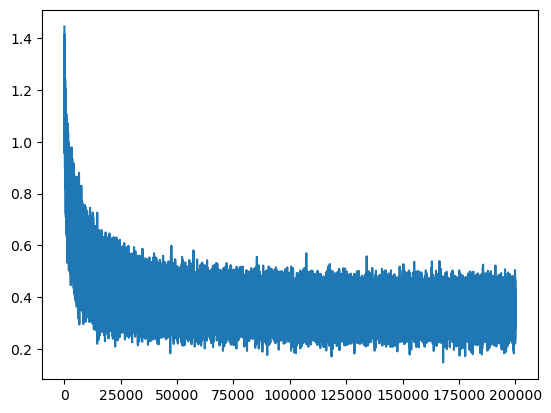

In [12]:
plt.plot(lossi)

In [13]:
#eval loss for All of Xtr and Ytr
@torch.no_grad()#this decorator disables gradient tracking

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]


    emb=C[x] #(N,block_size,e_embd)
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_sixe*n_embd)
    h=torch.tanh(embcat @ W1 +b1) #(N,n_hidden)
    logits=h @ W2 +b2 #(N,vocab_size)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')

train 2.2713024616241455
val 2.2880303859710693


In [14]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
mel.
ryah.
remers.
ekdraem.
aderedielin.
shy.
jen.
edellesoraan.
kayzioh.
karin.
shobergihimier.
kende.
jeyqien.
pucayu.
zen.
dariylynn.
eha.


# Expected loss at initialization

In [15]:
-torch.tensor(1/27).log()

tensor(3.2958)

In [16]:
#4 dim exaple of the issue
logits1=torch.tensor([0.0,0,0,0])
probs1=torch.softmax(logits1,dim=0)
loss1=-probs1[2].log() #initial loss for 3rd 0 here
loss1,probs1

(tensor(1.3863), tensor([0.2500, 0.2500, 0.2500, 0.2500]))

In [17]:
#4 dim exaple of the issue
logits1=torch.tensor([0.0,0,5,0]) # for 1 high no here, we will have low loss as assigning correct prob at initialising for the higher no but for others it will be high
probs1=torch.softmax(logits1,dim=0)
loss1=-probs1[2].log() #initial loss for 3rd 0 here
loss1,probs1
#try with random nos

(tensor(0.0200), tensor([0.0066, 0.0066, 0.9802, 0.0066]))

In [19]:
logits[0]

tensor([7.2866, 4.7324, 4.8451, 4.3038, 4.5225, 3.4702, 0.5164, 2.9453, 6.9032,
        5.8315, 2.9661, 3.0550, 5.2941, 5.1480, 7.2885, 1.2522, 0.9668, 0.0346,
        6.3455, 4.1244, 4.2673, 3.2525, 4.2369, 4.3369, 1.6655, 5.6446, 1.8723],
       grad_fn=<SelectBackward0>)

In [23]:
n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g)
b1=torch.randn(n_hidden, generator=g)
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact)
    logits=h @ W2 +b2 #32x27
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
        
# this is loss for this particular minibatch

11897
      0/ 200000: 3.3221
  10000/ 200000: 2.2241
  20000/ 200000: 2.4473
  30000/ 200000: 2.6137
  40000/ 200000: 1.9820
  50000/ 200000: 2.5756
  60000/ 200000: 2.4735
  70000/ 200000: 2.2249
  80000/ 200000: 2.2189
  90000/ 200000: 2.1875
 100000/ 200000: 2.0905
 110000/ 200000: 2.3009
 120000/ 200000: 1.9818
 130000/ 200000: 2.5578
 140000/ 200000: 2.3753
 150000/ 200000: 2.2236
 160000/ 200000: 1.9503
 170000/ 200000: 1.7899
 180000/ 200000: 2.0708
 190000/ 200000: 2.0296


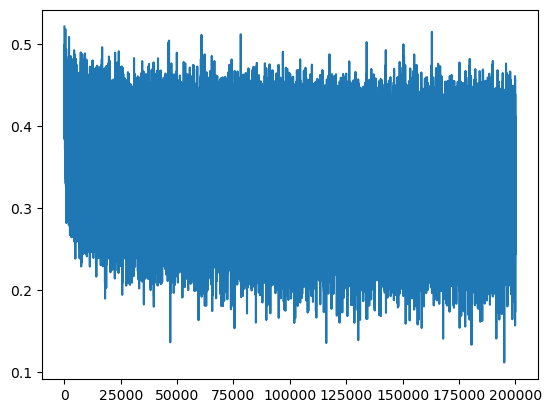

In [26]:
plt.plot(lossi)

In [24]:
#eval loss for All of Xtr and Ytr
@torch.no_grad()#this decorator disables gradient tracking

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]


    emb=C[x] #(N,block_size,e_embd)
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_sixe*n_embd)
    h=torch.tanh(embcat @ W1 +b1) #(N,n_hidden)
    logits=h @ W2 +b2 #(N,vocab_size)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')

train 2.1438074111938477
val 2.178218364715576


In [25]:
#just to compare

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndheyla.
renerstendraeg.
adelyn.
elin.
shi.
jen.
eden.
estanar.
kayzion.
kamin.
shubergshimiel.
kinde.
jennexnterianu.
zayven.
kylynn.
eli.
kaysh.


In [27]:
# 2nd problem: h 

In [28]:
h

tensor([[ 0.9998, -0.7777, -0.7847,  0.9911, -0.9999, -0.9993, -1.0000, -0.9988,
         -0.9946,  0.2324,  0.9999, -0.9922,  0.9822, -0.9784, -0.2283, -0.6373,
          0.9901,  0.9527, -1.0000, -1.0000,  1.0000,  1.0000, -0.0599, -0.9468,
          0.9999,  0.9996,  1.0000, -0.9999, -0.4166,  0.8876,  0.6281,  0.9894,
         -0.9925, -0.9999,  0.5476, -1.0000,  0.9998,  0.9615,  0.9994,  0.9915,
          0.8787, -0.9856,  1.0000,  0.9995, -0.9715, -0.9197,  1.0000, -0.9079,
         -0.8849,  0.3096, -0.9913, -1.0000,  0.9951,  0.0433, -0.9994,  0.8041,
         -0.7737, -0.9997, -0.9952, -1.0000, -0.9458, -0.9998, -0.5825,  1.0000,
          0.8730, -1.0000,  0.9942, -0.9999, -0.9947,  1.0000, -0.0679, -1.0000,
          0.9974,  0.9156,  0.3876, -0.9993, -0.9917, -1.0000, -1.0000, -1.0000,
         -1.0000,  0.9955,  0.9722, -0.8892,  0.9991,  0.9849,  0.9997,  0.9997,
         -1.0000, -1.0000, -1.0000,  0.9986, -0.9857, -0.9998, -1.0000, -0.9997,
         -0.9999,  0.9926, -

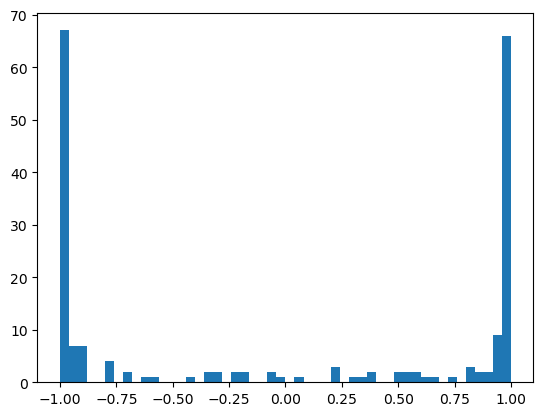

In [30]:
plt.hist(h.view(-1).tolist(),50);

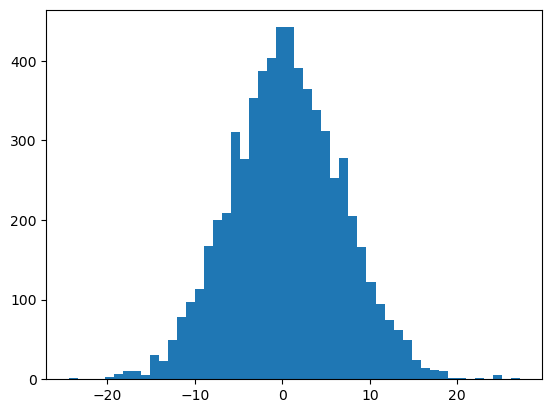

In [31]:
plt.hist(hpreact.view(-1).tolist(),50);

In [49]:
n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g)
b1=torch.randn(n_hidden, generator=g)
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact)
    logits=h @ W2 +b2 #32x27
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    
        
# this is loss for this particular minibatch

11897
      0/ 200000: 3.3221


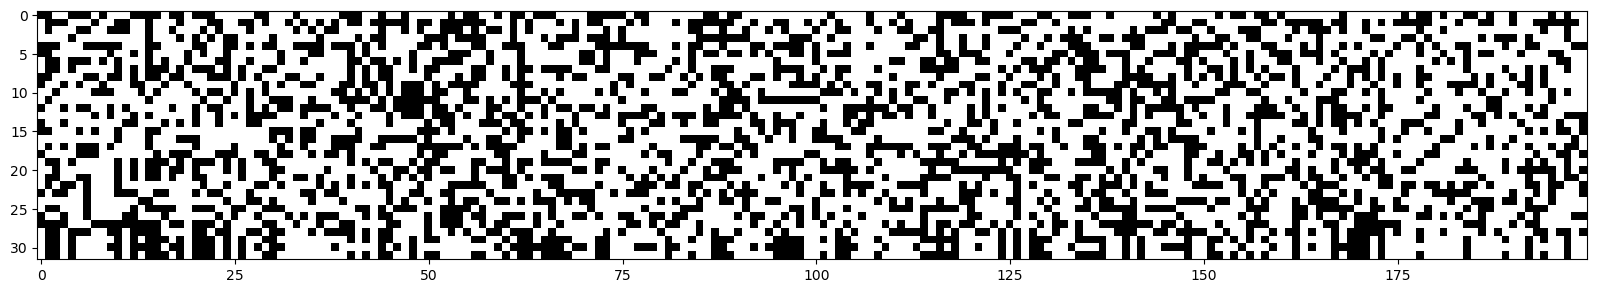

In [50]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest');
# 200 neuron, bullion tensor, white true, black false


In [54]:
# Solution to vanishing gradient

n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g) *0.2
b1=torch.randn(n_hidden, generator=g) *0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact)
    logits=h @ W2 +b2 #32x27
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    
        
# this is loss for this particular minibatch




11897
      0/ 200000: 3.3135


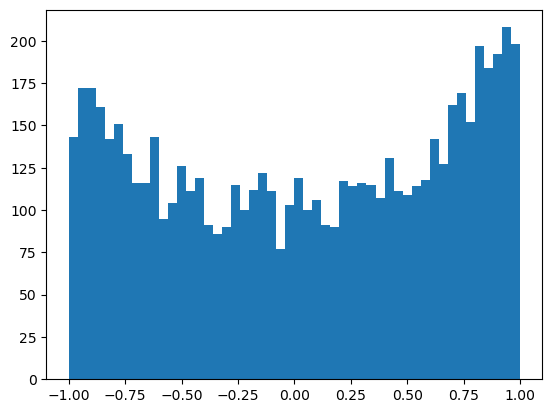

In [55]:
plt.hist(h.view(-1).tolist(),50);

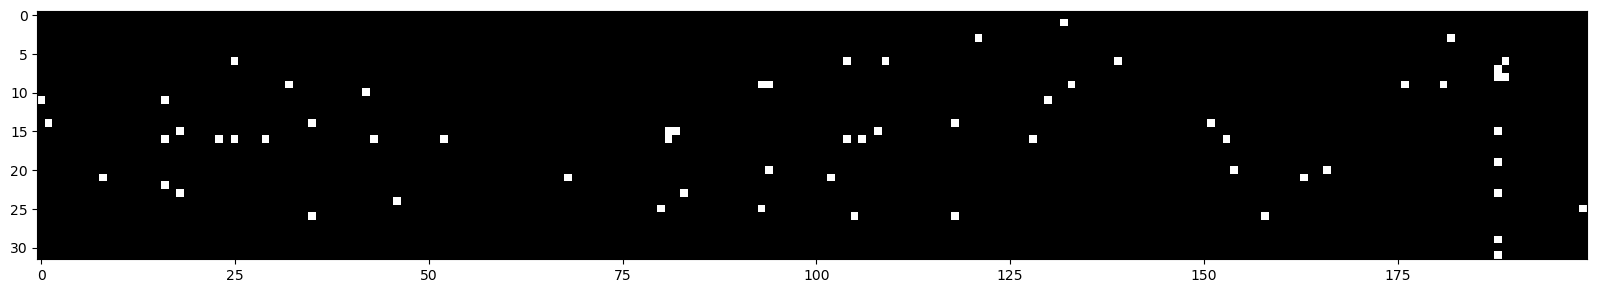

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest');
# 200 neuron, bullion tensor, white true, black false


In [58]:
# Solution to vanishing gradient

n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g) *0.2
b1=torch.randn(n_hidden, generator=g) *0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact)
    logits=h @ W2 +b2 #32x27
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
    
        
# above is loss for this particular minibatch

#eval loss for All of Xtr and Ytr
@torch.no_grad()#this decorator disables gradient tracking

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]


    emb=C[x] #(N,block_size,e_embd)
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_sixe*n_embd)
    h=torch.tanh(embcat @ W1 +b1) #(N,n_hidden)
    logits=h @ W2 +b2 #(N,vocab_size)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')


#just to compare

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

11897
      0/ 200000: 3.3135
  10000/ 200000: 2.2317
  20000/ 200000: 2.3488
  30000/ 200000: 2.5524
  40000/ 200000: 1.9776
  50000/ 200000: 2.5183
  60000/ 200000: 2.4216
  70000/ 200000: 2.0875
  80000/ 200000: 2.2269
  90000/ 200000: 2.1372
 100000/ 200000: 1.9769
 110000/ 200000: 2.1971
 120000/ 200000: 2.0112
 130000/ 200000: 2.4508
 140000/ 200000: 2.3213
 150000/ 200000: 2.2109
 160000/ 200000: 1.8588
 170000/ 200000: 1.7665
 180000/ 200000: 2.0286
 190000/ 200000: 1.8253
train 2.0986435413360596
val 2.13460111618042
mora.
amyazhizel.
ndery.
marethruthadraegan.
ered.
elin.
shi.
jen.
eden.
estanar.
elle.
malailin.
shubergihiriel.
kendreelynn.
noella.
ubreyce.
ryyah.
fael.
yuma.
mysanyah.


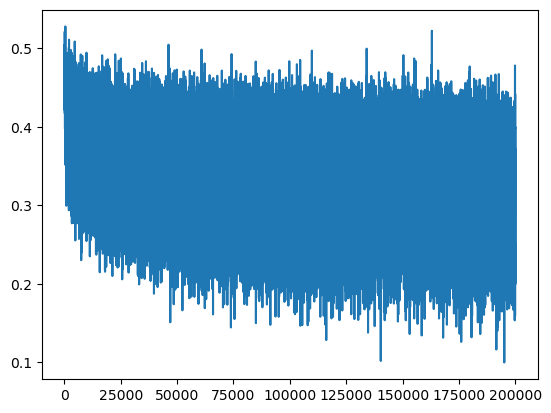

In [59]:
plt.plot(lossi)

till now

train 2.2713024616241455
val 2.2880303859710693

train 2.1438074111938477
val 2.178218364715576

train 2.0986435413360596
val 2.13460111618042

In [65]:
#ways to balance initial weights and biases (not by hand)

tensor(0.0075) tensor(1.0012)
tensor(-0.0027) tensor(3.1926)


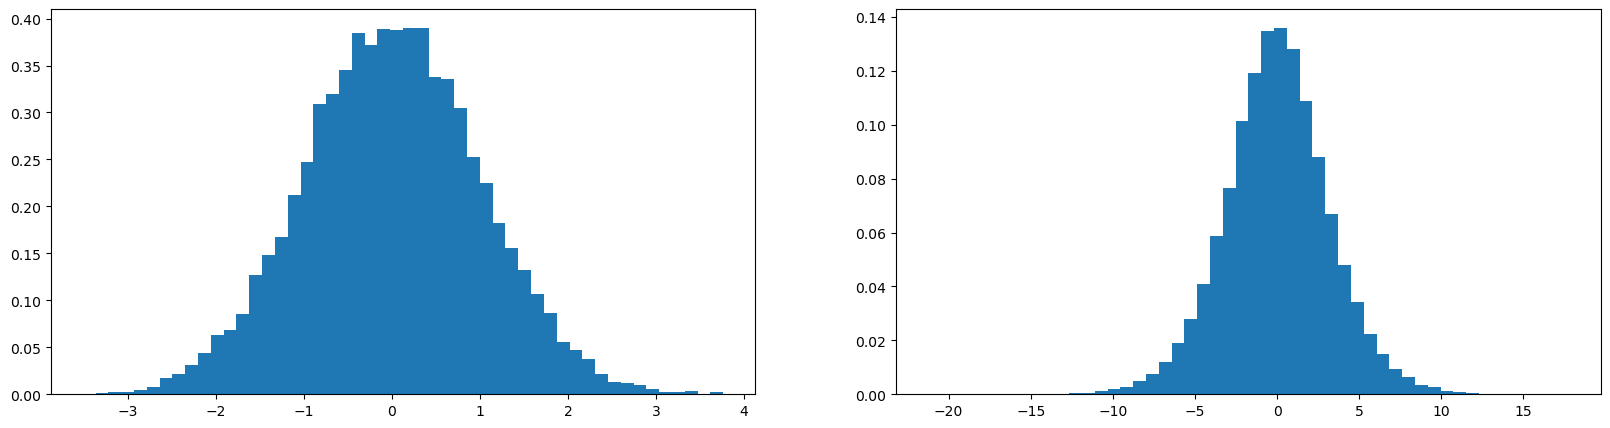

In [72]:
x=torch.randn(1000,10)
w=torch.randn(10,200)
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


tensor(-0.0185) tensor(1.0038)
tensor(-0.0392) tensor(15.7606)


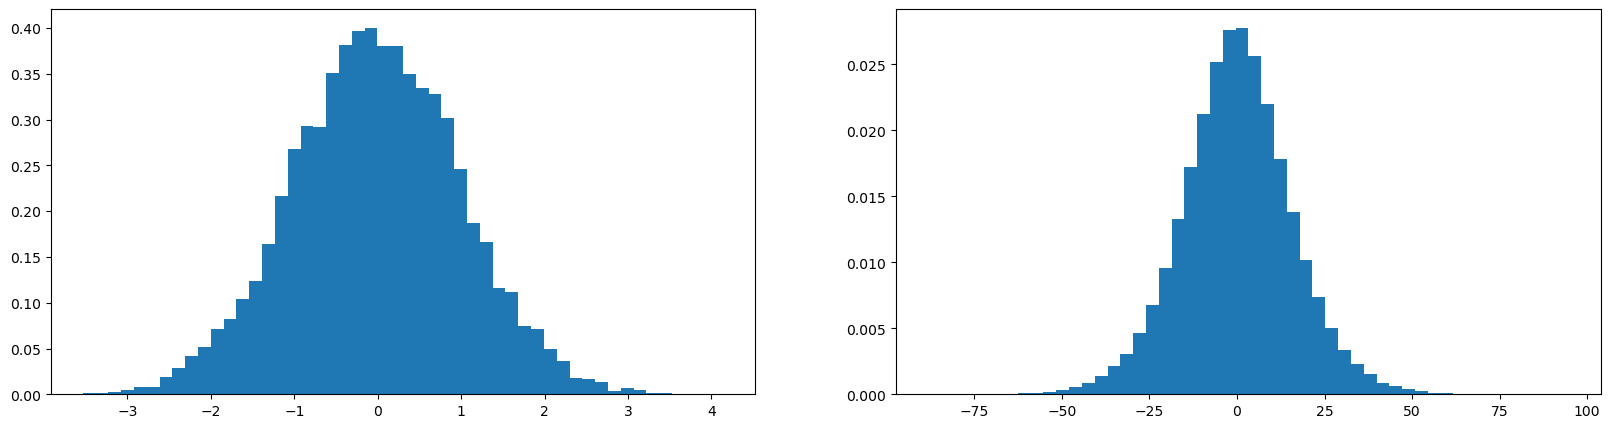

In [73]:
x=torch.randn(1000,10)
w=torch.randn(10,200)*5
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


tensor(0.0141) tensor(0.9931)
tensor(0.0009) tensor(0.6320)


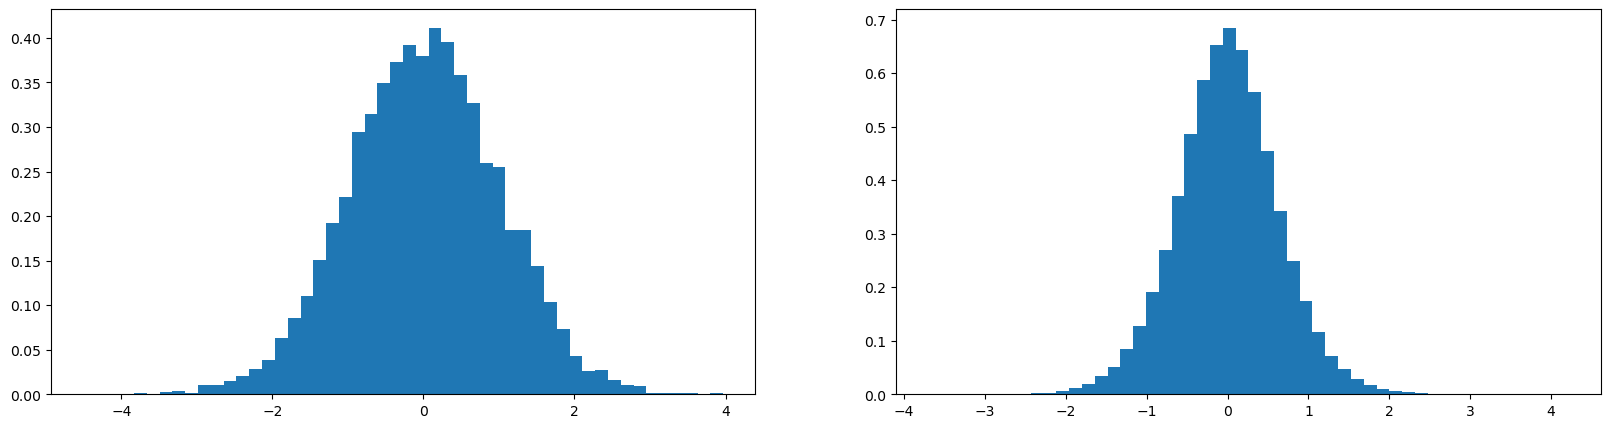

In [74]:
x=torch.randn(1000,10)
w=torch.randn(10,200)*.2
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


tensor(0.0048) tensor(0.9940)
tensor(0.0022) tensor(1.0165)


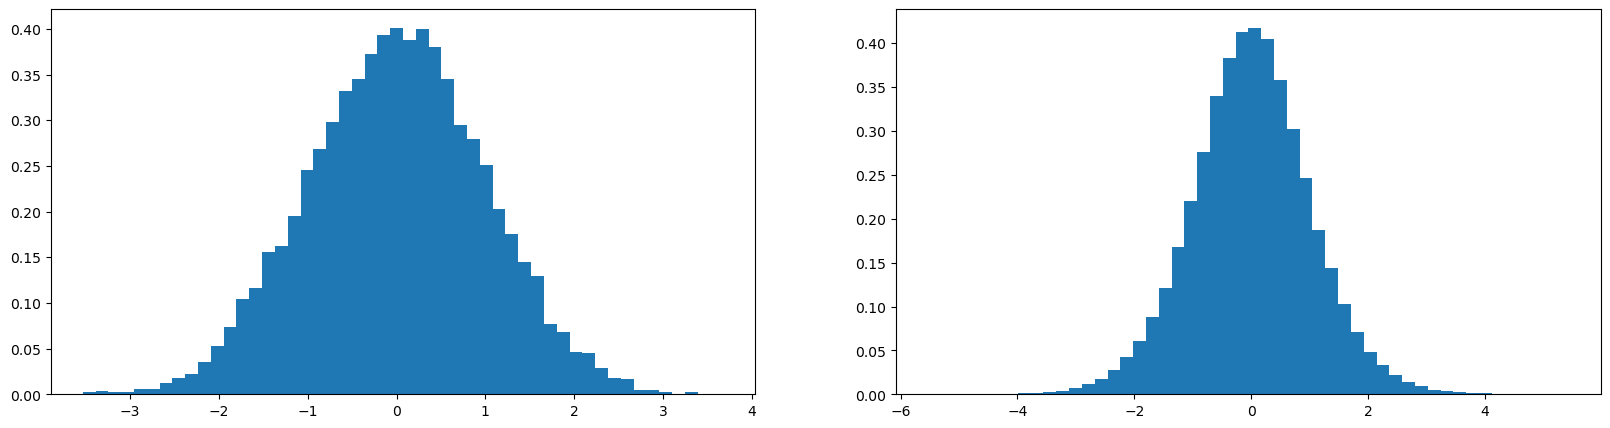

In [76]:
#what to multiply with exactly: fan in
x=torch.randn(1000,10)
w=torch.randn(10,200)/(10**.5)
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


In [77]:
#see paper: Delving deep into rectifiers... by Kaiming He

In [ ]:
#what to multiply with exactly: fan in
x=torch.randn(1000,10)
w=torch.randn(10,200)/(10**.5)
y=x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


In [90]:
(torch.randn(10000)*6).std()
#whatever u multiply with is the std, so when *ing W1 with .2, now using Kaiming gain/sqrt(fan_mode), tanh gain is 5/3

tensor(6.0527)

In [92]:
# (5/3)/ sqrt(n_embd * block_size)

In [93]:
n_embd * block_size

30

In [94]:
(5/3)/30**.5

0.3042903097250923

In [95]:

n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**.5 ) #*0.2
b1=torch.randn(n_hidden, generator=g) *0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0
parameters=[C,W1,b1,W2,b2]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact)
    logits=h @ W2 +b2 #32x27
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
    
        
# above is loss for this particular minibatch

#eval loss for All of Xtr and Ytr
@torch.no_grad()#this decorator disables gradient tracking

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]


    emb=C[x] #(N,block_size,e_embd)
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_sixe*n_embd)
    h=torch.tanh(embcat @ W1 +b1) #(N,n_hidden)
    logits=h @ W2 +b2 #(N,vocab_size)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')


#just to compare

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

11897
      0/ 200000: 3.3179
  10000/ 200000: 2.2267
  20000/ 200000: 2.3430
  30000/ 200000: 2.5715
  40000/ 200000: 1.9518
  50000/ 200000: 2.4814
  60000/ 200000: 2.4350
  70000/ 200000: 2.1068
  80000/ 200000: 2.2362
  90000/ 200000: 2.1444
 100000/ 200000: 2.0082
 110000/ 200000: 2.1776
 120000/ 200000: 1.9587
 130000/ 200000: 2.3588
 140000/ 200000: 2.2748
 150000/ 200000: 2.2320
 160000/ 200000: 1.8351
 170000/ 200000: 1.7559
 180000/ 200000: 1.9788
 190000/ 200000: 1.8739
train 2.099327802658081
val 2.1381173133850098
mon.
ammyazhiee.
med.
ryla.
ren.
ruthadraeg.
adelyn.
elin.
shi.
jenne.
elisson.
arleigh.
malaia.
noshuberging.
jest.
jair.
jennex.
terianu.
zenedi.
kylene.


#till now

#original
train 2.2713024616241455
val 2.2880303859710693

#fix softmax confidently wrong
train 2.1438074111938477
val 2.178218364715576

#fix tanh layer too saturated at initialization
train 2.0986435413360596
val 2.13460111618042

#with Kaiming=gain/sqrt(fan_mode)
train 2.099327802658081
val 2.1381173133850098


In [96]:
##Batch Normlization (BN)
#paper: BN: accelerating deep network... by Sergey Ioffe

In [97]:
hpreact.shape

torch.Size([32, 200])

In [100]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [99]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

In [102]:

n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**.5 ) #*0.2
b1=torch.randn(n_hidden, generator=g) *0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))

parameters=[C,W1,b1,W2,b2,bngain,bnbias]


print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2), embed cha into vec
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1 #hidden layer pre activation
    hpreact=bngain*(hpreact-hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True) + bnbias
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact) #hidden layer
    logits=h @ W2 +b2 #32x27 #output mlayer
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
    
        
# above is loss for this particular minibatch

#eval loss for All of Xtr and Ytr
@torch.no_grad()#this decorator disables gradient tracking

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]


    emb=C[x] #(N,block_size,e_embd) 
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_sixe*n_embd)
    hpreact=embcat@ W1+ b1
    hpreact=bngain*(hpreact-hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True) + bnbias

    h=torch.tanh(hpreact) #(N,n_hidden)
    
    logits=h @ W2 +b2 #(N,vocab_size), 
    loss=F.cross_entropy(logits,y) 
    print(split,loss.item())
    
split_loss('train')
split_loss('val')


#just to compare

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

12297
      0/ 200000: 3.3147
  10000/ 200000: 2.2824
  20000/ 200000: 2.4047
  30000/ 200000: 2.6029
  40000/ 200000: 1.9978
  50000/ 200000: 2.5340
  60000/ 200000: 2.4879
  70000/ 200000: 2.0455
  80000/ 200000: 2.2525
  90000/ 200000: 2.1438
 100000/ 200000: 2.1007
 110000/ 200000: 2.3819
 120000/ 200000: 2.0262
 130000/ 200000: 2.5101
 140000/ 200000: 2.4518
 150000/ 200000: 2.1937
 160000/ 200000: 2.0342
 170000/ 200000: 1.8907
 180000/ 200000: 2.1594
 190000/ 200000: 1.9128
train 2.129476547241211
val 2.1524293422698975
mridalmyazzizelvndhry.
marvivrschnd.
leg.
szeredgelingshppren.
die.
sustanarvellynn.
murlin.
shdbvrgshirin.
skjnnextlynn.
gwruswi.
brbycd.
rhyldnn.
mkshrishmysh.
lus.
hyl.
sadylynn.
jubrglvjunni.
crbrnsvevong.
prrdgnngnlynn.
shbptin.


In [ ]:
#till now

#original
train 2.2713024616241455
val 2.2880303859710693

#fix softmax confidently wrong
train 2.1438074111938477
val 2.178218364715576

#fix tanh layer too saturated at initialization
train 2.0986435413360596
val 2.13460111618042

#with Kaiming=gain/sqrt(fan_mode)
train 2.099327802658081
val 2.1381173133850098

#with batch norm (check)
train 2.129476547241211
val 2.1524293422698975

In [ ]:

n_embd=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647) #reproducible
C=torch.randn((vocab_size,n_embd), generator=g)
W1=torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**.5 ) #*0.2
b1=torch.randn(n_hidden, generator=g) *0.01
W2=torch.randn((n_hidden,vocab_size), generator=g)*0.01
b2=torch.randn(27, generator=g)*0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))

parameters=[C,W1,b1,W2,b2,bngain,bnbias]


print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True
#finalising LR
#reset parameters

lri=[]
lossi=[]
stepi=[]
batch_size=32
max_steps=200000

for i in range(max_steps): 
    
    #minibatch construct
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    #forward pass
    emb=C[Xb] #(32,3,2), embed cha into vec
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact=embcat@ W1+b1 #hidden layer pre activation
    hpreact=bngain*(hpreact-hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True) + bnbias
#     h=torch.tanh(emb.view(-1,n_embd * block_size) @ W1 +b1) #32x100
    h=torch.tanh(hpreact) #hidden layer
    logits=h @ W2 +b2 #32x27 #output mlayer
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for p in parameters:
        p.grad=None            #set gradients to 0

    loss.backward()

    #upgarde 
#     lr=lrs[i]              # we start with very less lr and go go upto -1
    lr=0.01
    for p in parameters:
        p.data+= -lr*p.grad 
        
    #track stats
    if i%10000==0:#print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break
    
        
# above is loss for this particular minibatch

#eval loss for All of Xtr and Ytr
@torch.no_grad()#this decorator disables gradient tracking

def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]


    emb=C[x] #(N,block_size,e_embd) 
    embcat=emb.view(emb.shape[0],-1) #concat into (N,block_sixe*n_embd)
    hpreact=embcat@ W1+ b1
    hpreact=bngain*(hpreact-hpreact.mean(0,keepdim=True))/hpreact.std(0,keepdim=True) + bnbias

    h=torch.tanh(hpreact) #(N,n_hidden)
    
    logits=h @ W2 +b2 #(N,vocab_size), 
    loss=F.cross_entropy(logits,y) 
    print(split,loss.item())
    
split_loss('train')
split_loss('val')


#just to compare

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size=3

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the sample
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

In [18]:
#Run this to avoid kernel dying when plotting

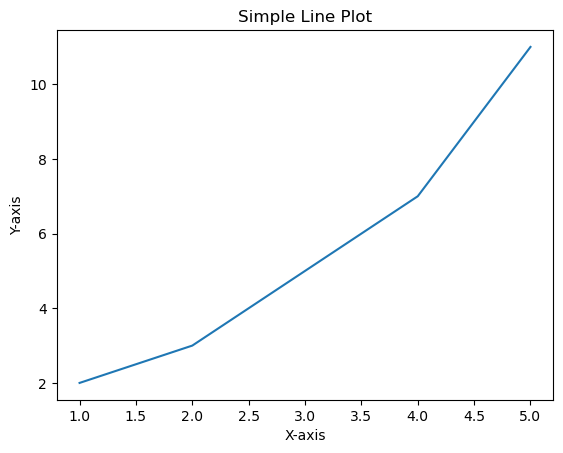

In [10]:
import matplotlib.pyplot as plt

# Define data
x = [1, 2, 3, 4, 5]
y = [2, 3, 5, 7, 11]

# Plot the line
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Line Plot')

# Show the plot
plt.show()


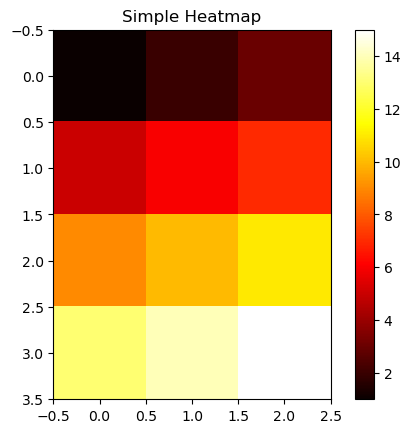

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Create a 4x4 tensor
tensor_data = torch.tensor([
    [1, 2, 3],
    [5, 6, 7],
    [9, 10, 11],
    [13, 14, 15]
], dtype=torch.int32)

# Convert the tensor to a NumPy array
array_data = tensor_data.numpy()

# Plot the heatmap
plt.imshow(array_data, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar to show the scale
plt.title('Simple Heatmap')  # Add a title
plt.show()